In [1]:
%load_ext autoreload
%autoreload 2
import os;

import tqdm
import pandas as pd
import numpy as np
import socceraction.vaep.features as fs
import socceraction.xthreat as xthreat

In [2]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [3]:
## Configure file and folder names, use SPADL format.
datafolder = "../data-fifa"
spadl_h5 = os.path.join(datafolder,"spadl-statsbomb.h5")

In [4]:
## Select games
games = pd.read_hdf(spadl_h5,"games")
games = games[games.competition_name == "FIFA World Cup"]
print("nb of games:", len(games))

actiontypes = pd.read_hdf(spadl_h5, "actiontypes")
bodyparts = pd.read_hdf(spadl_h5, "bodyparts")
results = pd.read_hdf(spadl_h5, "results")
players = pd.read_hdf(spadl_h5, "players")
players["player_name"] = players[["player_nickname","player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)

nb of games: 64


In [5]:
## Read in all actions of games
A = []

for game in tqdm.tqdm(list(games.itertuples())):
    actions = pd.read_hdf(spadl_h5,f"actions/game_{game.game_id}")
    actions = (
        actions.merge(actiontypes,how="left")
        .merge(results,how="left")
        .merge(bodyparts,how="left")
        #.sort_values(["period_id", "time_seconds", "timestamp"])
        .reset_index(drop=True)
    )
    [actions] = fs.play_left_to_right([actions],game.home_team_id)
        
    A.append(actions) 
    
A = pd.concat(A).reset_index(drop = True)

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:04<00:00, 12.82it/s]


(array([0, 1]), array([1427,  129], dtype=int64))


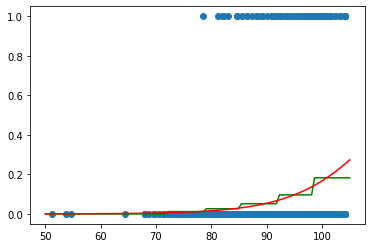

In [173]:
import matplotlib.pyplot as plt

shots = A[(A.type_name=='shot') & (A.result_id < 2)]
x = shots['start_x'].to_numpy().reshape(-1,1)
y = shots['result_id'].to_numpy()
plt.scatter(x, y)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

cell_width = (105 / 16)
clf1 = DecisionTreeClassifier()
clf1.fit(x // cell_width, y)

clf2 = LogisticRegression()
clf2.fit(x, y)

clf3 = SVC(gamma=0.01, probability=True)
clf3.fit(x, y)

print(np.unique(y, return_counts=True))

x = np.linspace(50,105,105).reshape(-1,1)
plt.plot(x, clf1.predict_proba(x // cell_width)[:,1], 'g')
plt.plot(x, clf2.predict_proba(x)[:,1], 'r')
# plt.plot(x, clf3.predict_proba(x)[:,1], 'b')

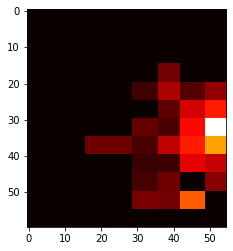

In [198]:
import matplotlib.pyplot as plt

shots = A[(A.type_name=='shot') & (A.result_id < 2)]
x = shots[['start_x','start_y']].to_numpy()
y = shots['result_id'].to_numpy()
# plt.scatter(x[:,0], x[:,1], s = 1, c = y)

cell_width = (105 / 16)
cell_height = (60 / 12)
clf1 = DecisionTreeClassifier()
clf1.fit(x // [cell_width, cell_height], y)

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

clf2 = make_pipeline(PolynomialFeatures(2), LogisticRegression())
clf2.fit(x, y)

x = np.arange(50,105)
y = np.arange(0,60)
a, b = np.meshgrid(x, y)

z1 = clf1.predict_proba(np.c_[a.ravel(), b.ravel()] // [cell_width, cell_height])[:,1].reshape(a.shape)
z2 = clf2.predict_proba(np.c_[a.ravel(), b.ravel()])[:,1].reshape(a.shape)

plt.imshow(z1, cmap='hot', interpolation='nearest')

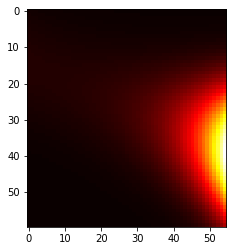

In [199]:
plt.imshow(z2, cmap='hot', interpolation='nearest')

In [85]:
np.array([[2,6],[7,7]]) // [5,2]

array([[0, 3],
       [1, 3]], dtype=int32)